# Predict Options Volatility Movement

### In this notebook, Instead of predicting the next day's Volailtility based on historical volatility, we will predict the binary variable — predict the movement up or down. 

### We will normalize our n-days window data only by their mean and variance (z-score normalization of Open, High, Low, Close), a multivariate time series. 

### We will use CNN as a classifier for building tensorflow LSTM model.

In [1]:
#initial Imports
import pandas as pd
import numpy as np
from  datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Convolution1D
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
%matplotlib inline

In [2]:
#read the data
def load_data(path):
    data = pd.read_csv(path, parse_dates=True, infer_datetime_format=True, delimiter=',', 
                       usecols=['Date', 'Open', 'High', 'Low', 'Close'], index_col='Date')
    data=data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

In [3]:
#process the data
def get_feature_target(data, window, fcast):
    X=[]
    y=[]
    for i in range(len(data)- window - fcast): 
            try:
                o = data.iloc[i:(i + window), 0]
                h = data.iloc[i:(i + window), 1] 
                l = data.iloc[i:(i + window), 2] 
                c = data.iloc[i:(i + window), 3] 

                # calculate z scores
                o = (o - np.mean(o))/np.std(o)
                h = (h - np.mean(h))/np.std(h)
                l = (l - np.mean(l))/np.std(l)
                c = (c - np.mean(c))/np.std(c)
  
               # y_j=[]
               # for j in range(fcast):
                if data.Close[i] <  data.Close[i+1] :
                    y_i=[1, 0]
                    #y_i.append([1, 0]) # up
                else:
                    y_i=[0, 1]
                    #y_i.append([0, 1]) # down
                x_i = np.column_stack((o, h, l, c))
                #y_i=np.column_stack(y_j)
            except Exception as e:
                break
                
            X.append(x_i)
            y.append(y_i)
            
    X, y = np.array(X), np.array(y)
    return X, y

In [4]:
#train the data
def get_train_test_data(features, target, emb_size, split):
    
    split=int(split*len(features))
    X_train = features[:split]
    X_test = features[split:]
    y_train = target[:split]
    y_test = target[split:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], emb_size))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], emb_size))
    
    return X_train, X_test, y_train, y_test

In [5]:
# Build & compile LSTM model. 
def build_compile_model(dropout_fraction, X_train, window, emb_size, loss):
    model = Sequential()
    #first convolution layer
    model.add(Convolution1D(input_shape = (window, emb_size),
                        filters=16,
                        kernel_size=4, padding='same'
                        ))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(dropout_fraction))
    
    #second convolution layer
    model.add(Convolution1D(filters=4,
                        kernel_size=4, padding='same'
                        ))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(dropout_fraction))
    
    model.add(Flatten())
    
    model.add(Dense(8))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
       
    # Compile the model
    model.compile(optimizer=Nadam(lr=0.002), 
              loss=loss,
              metrics=['accuracy'])
    
    return model

In [7]:
#fetch the data
file_dir= './resources/iv_data/amznvix.txt'
df=load_data(file_dir)
df.head()

,Open,High,Low,Close
Date,,,,
2010-11-08,38.50,38.93,37.36,37.38
2010-11-09,37.31,37.73,36.45,36.46
2010-11-10,36.02,36.52,34.93,35.43
2010-11-11,35.77,37.32,35.77,36.41
2010-11-12,36.43,39.39,36.04,39.12


In [8]:
# process the data and fetch the features and target
window =5 #n days window 
forecast = 1 # of days to predicted
features, target = get_feature_target(df, window, forecast)
print (features[:1], target[:1])

[[[ 1.70148256  0.90602754  1.56470191  0.33767033]
  [ 0.50622622 -0.23602398  0.42559892 -0.40198849]
  [-0.78947184 -1.38759259 -1.4770786  -1.23008478]
  [-1.04057611 -0.62622492 -0.42559892 -0.44218734]
  [-0.37766083  1.34381395 -0.08762331  1.73659028]]] [[0 1]]


In [9]:
#get scaled, train & test data
split_ratio =0.70
embedded_size = len(df.columns) # Number of features/columns embedded in X - in this case it is 4 (Open, high, low, close) 
X_train, X_test, y_train, y_test = get_train_test_data(features, target, embedded_size, split_ratio)

In [10]:
#build & compile the model by calling the function and passing the parameters
window=5
dropout=0.2
loss = "categorical_crossentropy"
model = build_compile_model(dropout, X_train, window, embedded_size, loss)

In [11]:
# display model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             272       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 16)             64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 4)              260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 4)              16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 4)              0

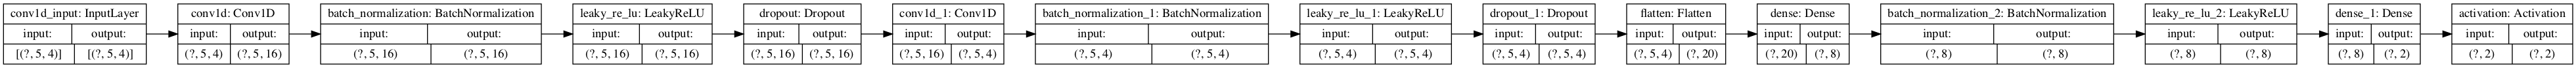

In [12]:
#plot model architecture
tf.keras.utils.plot_model(model, to_file='ibmconv1d.png', show_shapes=True, show_layer_names=True, 
                          rankdir='LR', expand_nested=True, dpi=96)

In [13]:
#train the model
model.fit(X_train, y_train, epochs = 100, 
          batch_size = 64, verbose=0, 
          validation_split=0.2, shuffle=False)

In [14]:
# Evaluate the model
model.evaluate(X_test, y_test, batch_size=10, verbose=1)

76/76 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.9814


[0.039347995072603226, 0.9814323782920837]

In [15]:
#make predictions 
pred = model.predict(np.array(X_test))

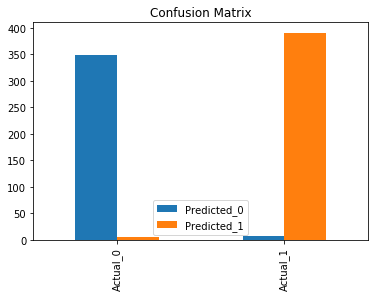

In [16]:
# evaluate model efficiency by plotting confusion matrix
c_matrix = pd.DataFrame(confusion_matrix([np.argmax(y) for y in y_test], [np.argmax(y) for y in pred]), columns=['Predicted_0', 'Predicted_1'], index=['Actual_0', 'Actual_1'])
c_matrix.plot(kind='bar', title='Confusion Matrix')

In [17]:
#create classification report
c_report = classification_report([np.argmax(y) for y in y_test], [np.argmax(y) for y in pred])
print(c_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       355
           1       0.98      0.98      0.98       399

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98      0.98      0.98       754

